### Importing the libraries

In [1]:
import torch 
import numpy as np
import pandas as pd

In [2]:
!pip install transformers

### Getting the training and validation data

In [3]:
# Train data
data =  pd.read_csv("../input/shl123/train_data.csv")
data.sample(10)

,input,labels
15085,I can not prove our answer is right .,1
19491,Contact us ocmda gmail .com,1
16756,Many people DON ' T THINK SO .,0
1559,afterwards will brew along with tea .,1
8520,"Now , I would like to talk about the teacher I...",1
12630,A natural disaster is not easy to control .,1
11998,What do you think of it ?,1
4179,Dry it in a sun light .,0
10164,So busy,0
5585,Good news,0


In [4]:
## Total No. of training sentences
len(data)

19998

In [5]:
# List of sentences and their labels
sentences = data.input.values
labels = data.labels.values

In [6]:
## Check how many negative samples and positive samples there are
incorrect  = data[data.labels==0]
correct = data[data.labels==1]

In [7]:
print("0 labelled sentences are: ",len(incorrect))
print("1 labelled sentences are: ",len(correct))

0 labelled sentences are:  9999
1 labelled sentences are:  9999


So we have equal no. of positive and negative samples which ensures no bias of one particular class in the dataset

In [8]:
## Helper function to find max length sentence and average length
def len_calcs(data):
  max_len = -1 
  max_sent = "" # Max length sentence
  lens = 0 # Total words in entire corpus
  for sentence in sentences:
    if len(sentence)>max_len:
      max_len = len(sentence.split(" "))
      max_sent = sentence
    lens+=len(sentence.split(" "))
  print(f"The max length sentence is {max_sent} of length {max_len}")
  print(f"The average length is {lens/len(data)}")
len_calcs(data)

The max length sentence is Corporate Governance To check whether the meeting records of the Board of Directors and Special Committee were complete and signed by directors who attended the meetings . To check the contents , deadline and signatures of the formal written authorization of shareholder representatives . To check whether scopes of authority were written in letters of authorization by the directors , the letters were signed by directors and the meeting records took down the trustees who attended the meetings . To read all the formal written meeting records and to check whether the frequency of arranging the Board meetings complies with articles of incorporation . To check the meeting records , resolutions and other related contents of Board of Supervisors and to check whether the frequency of arranging the meeting complies with articles of incorporation . To check the meeting records , resolutions and other related contents of the three Special Committees and whether the frequ

### BERT TOKENIZER

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.
Reference: https://arxiv.org/abs/1810.04805

In [9]:
# Loading the BERT Tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_cased=True)

In [10]:
# Original sentence
print('Original: ',sentences[1])

# Sentence split into tokens

print("Tokenized: ",tokenizer.tokenize(sentences[1]))

Original:  I am not interested in cars or electric appliances .
Tokenized:  ['i', 'am', 'not', 'interested', 'in', 'cars', 'or', 'electric', 'appliances', '.']


In [11]:
## We now tokenize the entire training dataset and map the tokens to their ID's

def create_dataset(sentences,labels):
  ids = []
  atten_masks = []

  for sentence in sentences:
    ''' encode_plus: (1) Tokenize the sentence
                    (2) Prepend [CLS] start token to the beginning to indicate start of sentence
                    (3) Append [SEP] end token to the end
                    (4) Map tokens to IDs
                    (5) Pad or truncate sentence to max_length
                    (6) Create attention masks to ignore [PAD] tokens
    '''
    encoded_sentences = tokenizer.encode_plus(sentence,
                                              add_special_tokens=True, #Add [CLS and [SEP]
                                              max_length=128,
                                              pad_to_max_length=True,
                                              return_attention_mask = True,
                                              return_tensors = 'pt' # Return pytorch tensors
                                              )
    # Add the encoded sentence to the list. 
    ids.append(encoded_sentences['input_ids'])
    # Attention mask differentiates padding from non-padding tokens
    atten_masks.append(encoded_sentences['attention_mask'])
  # Convert lists to tensors
  ids = torch.cat(ids,dim=0)
  atten_masks = torch.cat(atten_masks,dim=0)  
  labels = torch.tensor(labels)
  return ids,atten_masks,labels 

ids,atten_masks,labels= create_dataset(sentences,labels)



print("Original: ",sentences[1])
print("Token IDs: ",ids[1])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I am not interested in cars or electric appliances .
Token IDs:  tensor([  101,  1045,  2572,  2025,  4699,  1999,  3765,  2030,  3751, 22449,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,   

All these 0's indicate padding tokens

##### Loading the validation dataset and splitting into tokens

In [12]:
val_data = pd.read_csv('../input/shl123/val_data.csv')
val_ids,val_atten_masks,val_labels = create_dataset(val_data.input.values,val_data.labels.values)

In [13]:
from torch.utils.data import TensorDataset
dataset = TensorDataset(ids,atten_masks,labels)
val_dataset = TensorDataset(val_ids,val_atten_masks,val_labels)

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32. 
# Reference: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
batch_size = 16

train_dataloader = DataLoader(dataset,sampler=RandomSampler(data),batch_size=batch_size)
val_dataloader = DataLoader(val_dataset,sampler=SequentialSampler(val_data),batch_size=batch_size)



### Train Our Classification Model

We use the BertForSequenceClassification model for this task. The relevant details of the model is provided at https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification

We finetune BERT to get our required model

In [15]:
from transformers import BertForSequenceClassification,AdamW,BertConfig 
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # Using 12 layer BERT model, with an uncased vocab
    num_labels = 2, # Number of o/p labels
    output_attentions=False, # Whether model wil return attn weights
    output_hidden_states=False # whether model returns hidden states
)
# Run the model on GPU
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Optimizing and Learning rate Schedule

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper)

Batch size: 16, 32

Learning rate (Adam): 5e-5, 3e-5, 2e-5

Number of epochs: 2, 3, 4

In [16]:
optimizer = AdamW(model.parameters(),
                  lr=2e-5, # learning rate
                  eps=1e-8 #epsilon: an error tolerance factor
                  )

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [17]:
# Create a learning rate schedule
from transformers import get_linear_schedule_with_warmup 
epochs = 2
total_steps = len(train_dataloader)*epochs
scheduler =get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [18]:
## Helper Functions for F1_score and precision
def f1_score(preds,labels):
  preds = np.argmax(preds,axis=1).flatten()
  labels = labels.flatten()
  tp = np.sum((preds==labels) & (labels==1)) 
  fp = np.sum((preds!=labels) & (preds==1))
  fn = np.sum((preds!=labels) & (preds==0)) 
  precision = tp/(tp+fp)
  recall  = tp/(tp+fn)
  f1 = 2*(precision*recall)/(precision+recall)
  return f1

def precision(preds,labels):
  preds = np.argmax(preds,axis=1).flatten()
  labels = labels.flatten()
  tp = np.sum((labels==1) & (preds==labels)) 
  fp = np.sum((preds!=labels) & (preds==1))
  precision = tp/(tp+fp)
  return precision

In [19]:
device = torch.device("cuda")

In [20]:
training_stats = []
for epoch in range(0,epochs):
  print(f'====== Epoch {epoch} / {epochs}')
  print("Training...")

  train_loss  = 0 
  model.train()
  # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-

  for batch in train_dataloader:
    b_ids = batch[0].to(device)
    b_input_mask  = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-
    model.zero_grad()

    #forward pass
    res = model(b_ids,
                           token_type_ids=None,
                           attention_mask = b_input_mask,
                           labels=b_labels)
    loss,logits  = (res[0],res[1])
    train_loss +=loss.item()


    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Graient clipping to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)

    # Update params
    optimizer.step()

    # Update learning rate
    scheduler.step()

  avg_train_loss = train_loss/len(train_dataloader)
  print(f" Average Training Loss: {avg_train_loss}")

  print("\n Validation....")
  
  model.eval()

  total_eval_precision = 0
  total_eval_f1 = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  for batch in val_dataloader:
     b_input_ids = batch[0].to(device)
     b_input_mask = batch[1].to(device)
     b_labels = batch[2].to(device)
     # Tell pytorch not to bother with constructing the compute graph during
     # the forward pass, since this is only needed for backprop (training).
     with torch.no_grad():
       res = model(b_input_ids,token_type_ids=None,attention_mask=b_input_mask,labels=b_labels)
       loss,logits = (res[0],res[1])
     total_eval_loss+=loss.item()
     logits = logits.detach().cpu().numpy()
     label_ids = b_labels.to('cpu').numpy()
     total_eval_precision +=precision(logits,label_ids)
     total_eval_f1 +=f1_score(logits,label_ids)
  avg_val_loss = total_eval_loss/len(val_dataloader)
  avg_precision = total_eval_precision/len(val_dataloader)
  avg_f1 = total_eval_f1/len(val_dataloader)
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation Precision: {0:.2f}".format(avg_precision))
  print("  Validation F1: {0:.2f}".format(avg_f1))

  training_stats.append({
      'epoch':epoch+1,
      'Training Loss':avg_train_loss,
      'Valid. Loss': avg_val_loss,
      'Valid. Precision': avg_precision,
      'Valid. F1':avg_f1
  })


====== Epoch 0 / 2
Training...
 Average Training Loss: 0.6594457279443741

 Validation....
  Validation Loss: 0.66
  Validation Precision: 0.56
  Validation F1: 0.68
====== Epoch 1 / 2
Training...
 Average Training Loss: 0.5883319868564606

 Validation....
  Validation Loss: 0.69
  Validation Precision: 0.56
  Validation F1: 0.66


In [21]:
stats = pd.DataFrame(training_stats)
stats.set_index('epoch',inplace=True)
stats

,Training Loss,Valid. Loss,Valid. Precision,Valid. F1
epoch,,,,
1,0.659446,0.664797,0.557294,0.683051
2,0.588332,0.692627,0.562185,0.660756


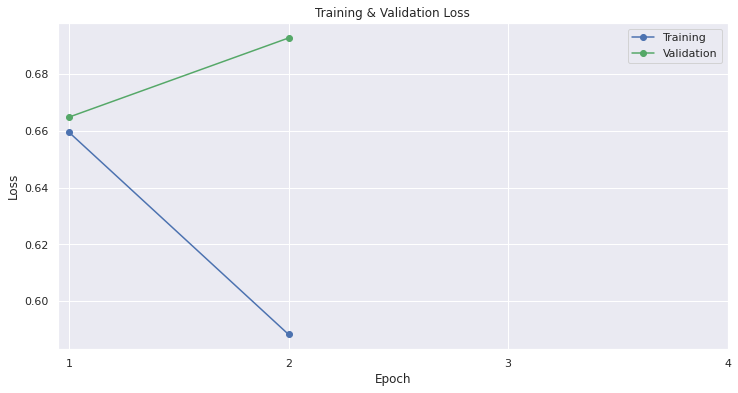

In [22]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(stats['Training Loss'], 'b-o', label="Training")
plt.plot(stats['Valid. Loss'], 'g-o', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

### Testing the model

In [23]:
import os
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model,'module') else model
model_to_save.save_pretrained(output_dir)


In [24]:
model = BertForSequenceClassification.from_pretrained('./model_save')
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [25]:
torch.cuda.empty_cache()

In [26]:
test_data = pd.read_csv('../input/shl123/test_data.csv')
sentences = test_data.input.values
output = []
test_ids,test_atten_masks,labels = create_dataset(sentences,[])
test_dataset = TensorDataset(test_ids,test_atten_masks)
test_dataloader = DataLoader(test_dataset,sampler=SequentialSampler(test_dataset),batch_size=batch_size)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [27]:
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  predictions.append(logits)

In [28]:
out = []
for batch in predictions:
    for pred in batch:
        label = np.argmax(pred)
        out.append(label)

In [29]:
test_data['labels'] =out

In [30]:
test_data.head()

,input,labels
0,I believe they will master Japanese soon becau...,1
1,I am looking for it .,1
2,Apple is a round fruit with smooth and colorfu...,0
3,Let It Will Be Push .,0
4,I rode on this ship from Sendai .,0


In [31]:
test_data.to_csv('Roushan_Raj_submission.csv')